# Problem statement
Traffic Flow Prediction Dataset: The goal for this dataset is to forecast the Spatio-temporal traffic volume based on the historical traffic volume and other features in neighboring locations. Specifically, the traffic volume is measured every 15 minutes at 36 sensor locations along two major highways in the Northern Virginia/Washington D.C. capital region. The 47 features include: 1) the historical sequence of traffic volume sensed during the 10 most recent sample points (10 features), 2) weekday (7 features), 3) hour of the day (24 features), 4) road direction (4 features), 5) a number of lanes (1 feature), and 6) name of the road (1 feature). The goal is to predict the traffic volume for 15 minutes into the future for all sensor locations. With a given road network, we know the spatial connectivity between sensor locations.


# Import ML/Python Libraries 

Python3 version 3.10.6 and ML/Python Libraries are used for data analysis and analytics. ML/Python Libraries are pandas, numpy, seaborn, networkx, matplotlib, scipy, sklearn.

##### Uncomment the below code to install the required ML/Python Libraries
#! pip install pandas, numpy, seaborn, networkx, matplotlib, scipy, sklearn



In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import metrics

# set display option
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# ignore warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Traffic Flow Prediction Dataset

In [2]:
# Load Traffic Flow Prediction Dataset
annots = loadmat("traffic_dataset.mat")
print(annots.keys())

dict_keys(['__header__', '__version__', '__globals__', 'tra_X_tr', 'tra_X_te', 'tra_Y_tr', 'tra_Y_te', 'tra_adj_mat'])


In [3]:
# Extract DataFrame 
tra_X_te = pd.DataFrame(annots['tra_X_te'])
tra_X_tr = pd.DataFrame(annots['tra_X_tr'])

tra_Y_tr = pd.DataFrame(annots['tra_Y_tr'])
tra_Y_te = pd.DataFrame(annots['tra_Y_te'])

tra_adj_mat = pd.DataFrame(annots['tra_adj_mat'])


print("tra_X_te: ", tra_X_te.shape)
print("tra_X_tr: ", tra_X_tr.shape)
print("tra_Y_te: ", tra_Y_te.shape)
print("tra_Y_tr: ", tra_Y_tr.shape)
print("tra_adj_mat: ", tra_adj_mat.shape)

tra_X_te:  (1, 840)
tra_X_tr:  (1, 1261)
tra_Y_te:  (36, 840)
tra_Y_tr:  (36, 1261)
tra_adj_mat:  (36, 36)


# Utility functions

In [4]:
# Create Label from array of matrices
def fn_create_label(df_name, y_size):
    '''
    This function creates the label/target variable.
    Input: 
        df_name: Name of the Dataframe
        y_size: the size of contiguous quarter hours
    Output:
        df: Dataframe        
    '''
    df = pd.DataFrame()
    for i in range(y_size):
        # newDf =  df[i]
        df = pd.concat([df, df_name[i]], ignore_index = True)

    return df

# Extract dataframe from array of matrices
def fn_concat_x(variableName, size):
    '''
    This function creates the predictor variable.
    Input: 
        df_name: Name of the Dataframe
        y_size: the size of contiguous quarter hours
    Output:
        df: Dataframe        
    '''
    df = pd.DataFrame()
    for i in range(size):
        # print(i)
        newDf = pd.DataFrame(variableName[0][i].toarray()) 
        sensor_id = pd.DataFrame(pd.Series([x for x in range(36)]))
        newDf['sensor_id'] = sensor_id
        df = pd.concat([df, newDf], ignore_index=True)
    return df

# Feature selection of the given dataset for model building
def feature_ranking(X, Y, colnames):
    '''
    This function is used to select relevant features for the machine learning model. 
    Feature Selection is the method of reducing the input variable to the model by using 
    only relevant data and getting rid of noise in data. 
    Input:
        X: Predictor variable
        Y: Label/target variable
        colnames: Name of the predictor variable
    
    Output:
        
        meanplot: Mean ranking of the predictor variable for features selection/ranking
    
    '''
    # Define dictionary to store our rankings
    ranks = {}
    # Create our function which stores the feature rankings to the ranks dictionary
    def ranking(ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x,2), ranks)
        return dict(zip(names, ranks))

    # Construct Recursive Feature Elimination (RFE) of the Linear Regression model
    lr = LinearRegression()
    lr.fit(X,Y)

    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, ) #verbose =3
    rfe.fit(X,Y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

    # Decision Tree Regressor
    dt = DecisionTreeRegressor()
    dt.fit(X,Y)
    ranks["DT"] = ranking(dt.feature_importances_, colnames)

    # Random Forest Regressor
    rf = RandomForestRegressor(n_jobs=-1, n_estimators=9, ) #verbose=3
    rf.fit(X,Y)
    ranks["RF"] = ranking(rf.feature_importances_, colnames)

    """ Creating the Feature Ranking Matrix: We combine the scores from the various methods above and output 
    it in a matrix form for convenient viewing as such:"""

    # Create empty dictionary to store the mean value calculated from all the scores
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)


    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    # Put the mean scores into a Pandas dataframe
    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    
    return meanplot

# Data understanding and data preparation
This section details the data understanding and preparation of the traffic flow prediction dataset. In this section, Created the train and test dataframe from the traffic flow prediction dataset for machine learning. Restructured the dataset and added columns like sensor_id derived from the ‘36 sensors’ and merged the predictor and target/label variables. The following two functions are used to create the dataframe from the traffic flow prediction dataset.

fn_create_label()
This function is used to create the label/target variable from the traffic flow prediction dataset. The create_label() function takes input as df_name- Name of the Dataframe and  y_size- the size of contiguous quarter hours. This function returns the result as the df- Dataframe.      

fn_concat_x() 
fn_concat_x() function is used  to create the predictor variable. The fn_concat_x()  takes input as df_name- Name of the Dataframe and y_size: the size of contiguous quarter hours. The fn_concat_x() function returns the result as the df- Dataframe.      

Performed the data understanding by printing a few rows of the dataframe and checked the missing values and data type etc. of the traffic flow dataset.

Export the merged training and testing dataset into CSV file format for further analysis and analytics.


In [5]:
# Create train Dataframe 
tra_X_tr = fn_concat_x(annots['tra_X_tr'], 1261)
label = fn_create_label(tra_Y_tr, 1261)
label.columns = ['label']
trainDf = pd.concat([tra_X_tr, label], axis=1, ignore_index=True)
print("trainDf shape: ", trainDf.shape)

# Create test Dataframe
tra_X_te = fn_concat_x(annots['tra_X_te'], 840)
label = fn_create_label(tra_Y_te, 840)
label.columns = ['label']
testDf = pd.concat([tra_X_te, label], axis=1, ignore_index=True)
print("testDf shape: ", testDf.shape)

trainDf shape:  (45396, 50)
testDf shape:  (30240, 50)


In [6]:
# print first five rows of the trainDf 
trainDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.092480,0.096684,0.070061,0.065857,0.078468,0.071462,0.054180,0.044372,0.054647,0.050911,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.050911
1,0.097151,0.102289,0.081738,0.076600,0.072396,0.067725,0.058851,0.066324,0.059785,0.056983,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.046240
2,0.115367,0.110696,0.105558,0.095283,0.067725,0.080336,0.062588,0.061653,0.055582,0.061653,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.050444
3,0.112097,0.102756,0.092013,0.083606,0.062121,0.070995,0.053713,0.062588,0.053713,0.066791,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,0.044839
4,0.127043,0.150864,0.131714,0.106025,0.099019,0.090612,0.069127,0.060719,0.060719,0.067258,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,0.044839


In [7]:
# print the info of train dataframe
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45396 entries, 0 to 45395
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       45396 non-null  float64
 1   1       45396 non-null  float64
 2   2       45396 non-null  float64
 3   3       45396 non-null  float64
 4   4       45396 non-null  float64
 5   5       45396 non-null  float64
 6   6       45396 non-null  float64
 7   7       45396 non-null  float64
 8   8       45396 non-null  float64
 9   9       45396 non-null  float64
 10  10      45396 non-null  float64
 11  11      45396 non-null  float64
 12  12      45396 non-null  float64
 13  13      45396 non-null  float64
 14  14      45396 non-null  float64
 15  15      45396 non-null  float64
 16  16      45396 non-null  float64
 17  17      45396 non-null  float64
 18  18      45396 non-null  float64
 19  19      45396 non-null  float64
 20  20      45396 non-null  float64
 21  21      45396 non-null  float64
 22

In [8]:
# Check the missing values
trainDf.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
dtype: int64

In [9]:
# Noise on Day-of-Week Features (Features 10 to Features 16)
count = 0
sum = 0.0
for i in range(45396):
    for j in np.arange(10,17):
        sum = sum + trainDf.iloc[i][j]
    if sum == 2.0:
        count += 1
    sum = 0.0
print(f'Noise on Day-of-Week Features (Features 10 to Features 16) is: {round(count/45396 * 100, 2)} %')

Noise on Day-of-Week Features (Features 10 to Features 16) is: 8.88 %


In [10]:
#Create CSV file
trainDf.to_csv("trafic_train.csv", index=True)

testDf.to_csv("trafic_test.csv", index=True)

# Exploratory Data Analysis (EDA)
This section discovers the trends and patterns in the dataset and understands the relationship between various variables.

Exploratory Data Analysis (EDA) is an approach we used to analyse the data using visual techniques. EDA is used to check assumptions with the help of statistical summaries and graphical representations. 


In [11]:
# read .CSV files
trainDf = pd.read_csv("trafic_train.csv", index_col=0)
testDf = pd.read_csv("trafic_test.csv", index_col=0)
# trainDf.reset_index(inplace = True)
# testDf.reset_index(inplace = True)
trainDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.092480,0.096684,0.070061,0.065857,0.078468,0.071462,0.054180,0.044372,0.054647,0.050911,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.050911
1,0.097151,0.102289,0.081738,0.076600,0.072396,0.067725,0.058851,0.066324,0.059785,0.056983,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.046240
2,0.115367,0.110696,0.105558,0.095283,0.067725,0.080336,0.062588,0.061653,0.055582,0.061653,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.050444
3,0.112097,0.102756,0.092013,0.083606,0.062121,0.070995,0.053713,0.062588,0.053713,0.066791,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,0.044839
4,0.127043,0.150864,0.131714,0.106025,0.099019,0.090612,0.069127,0.060719,0.060719,0.067258,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,0.044839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45391,0.037366,0.036432,0.031761,0.029426,0.035497,0.066791,0.070061,0.093414,0.092947,0.141523,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,31,0.184026
45392,0.006539,0.003270,0.002802,0.006539,0.006539,0.002335,0.009809,0.014012,0.015880,0.021952,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,32,0.043438
45393,0.034096,0.025689,0.031761,0.026156,0.026623,0.036432,0.053246,0.059785,0.075666,0.103223,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,33,0.142457
45394,0.043905,0.041102,0.047641,0.033162,0.037366,0.055114,0.074264,0.082672,0.111630,0.157870,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,34,0.210649


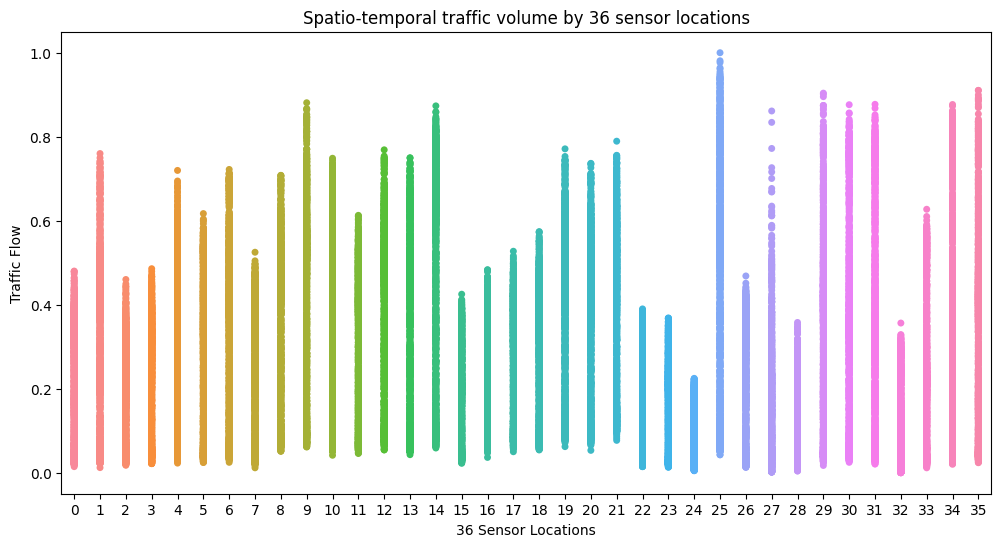

In [12]:
# Spatio-temporal traffic volume by 36 sensor locations
f, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(x="48", y="49", data=trainDf, jitter=False)
plt.title("Spatio-temporal traffic volume by 36 sensor locations")
plt.xlabel('36 Sensor Locations')
plt.ylabel('Traffic Flow')
plt.show()

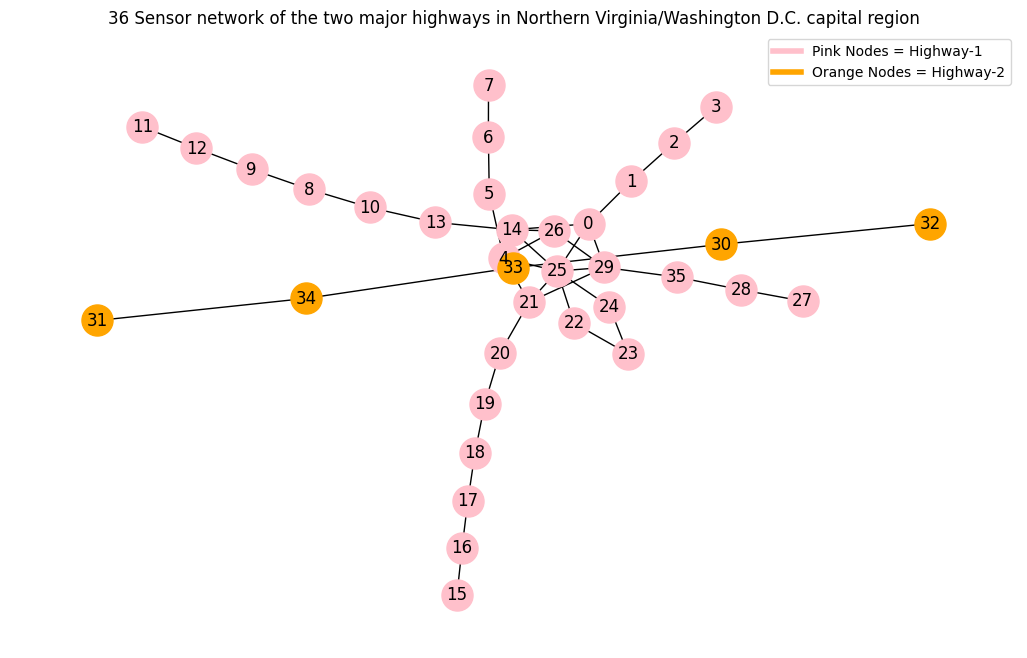

In [13]:
# 36 Sensor network of the two major highways in Northern Virginia/Washington D.C. capital region
data_set = loadmat("traffic_dataset.mat")
df_tra_X_tr = pd.DataFrame(data_set['tra_X_tr'][0][1].toarray())
tra_adj_mat = pd.DataFrame(data_set['tra_adj_mat'])

G = nx.graph.Graph()

for i in range(tra_adj_mat.shape[0]):
    for j in range(tra_adj_mat.shape[0]):
        if tra_adj_mat[i][j] == 1:
            G.add_edge(i, j)

custom_lines = [Line2D([0], [0], color='pink', lw=4),
                Line2D([0], [0], color='orange', lw=4)]

node_list_road_1 = [i for i in range(36) if df_tra_X_tr.loc[:,47][i] == 0.0]
node_list_road_2 = [i for i in range(36) if df_tra_X_tr.loc[:,47][i] == 1.0]

G1=G.subgraph(node_list_road_1)
G2=G.subgraph(node_list_road_2)
fig, ax = plt.subplots(figsize=(13,8))
nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_color='pink', node_size=500, with_labels = True, ax=ax)
nx.draw(G2, pos=nx.kamada_kawai_layout(G2),node_color='orange', node_size=500, with_labels = True, ax=ax)
plt.legend(custom_lines, ['Pink Nodes = Highway-1', 'Orange Nodes = Highway-2'], loc='upper right')
plt.title("36 Sensor network of the two major highways in Northern Virginia/Washington D.C. capital region")
plt.show()

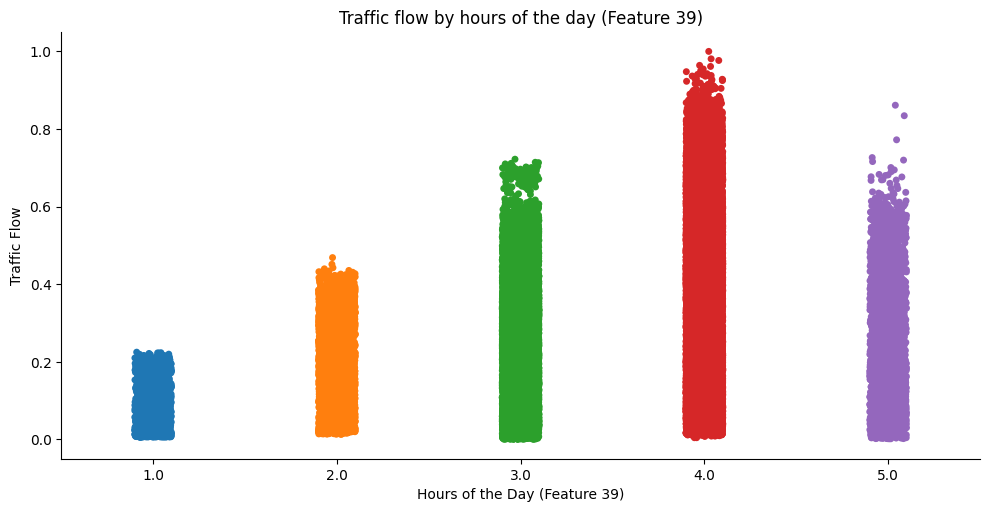

In [14]:
# Traffic flow by hours of the Day
sns.catplot(x="39", y="49", data=trainDf, jitter=True, height=5,aspect=2)
plt.title("Traffic flow by hours of the day (Feature 39)")
plt.xlabel('Hours of the Day (Feature 39)')
plt.ylabel('Traffic Flow')
plt.show()

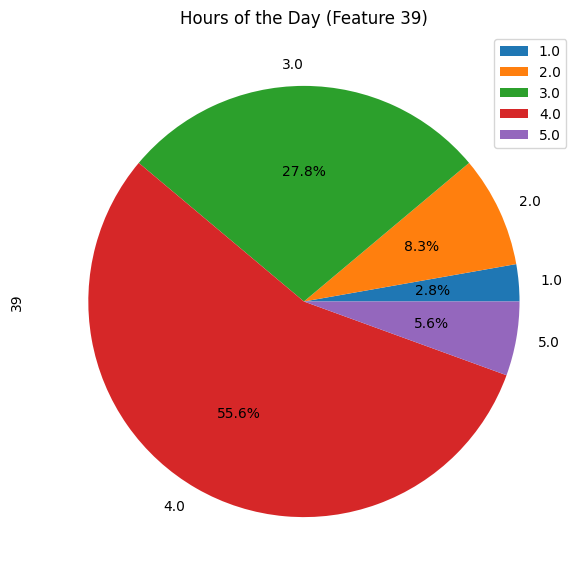

In [15]:
# Hours of the Day (Feature 39) in percentage 
(trainDf.groupby('39')['39'].count()).plot.pie(autopct='%1.1f%%',figsize=(9,7), legend = True)
plt.title("Hours of the Day (Feature 39)")
plt.show()

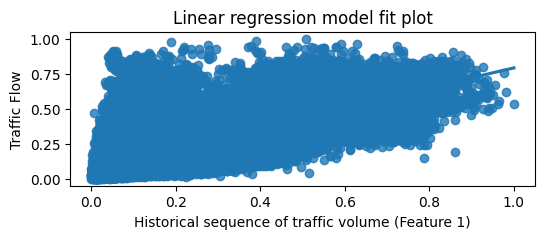

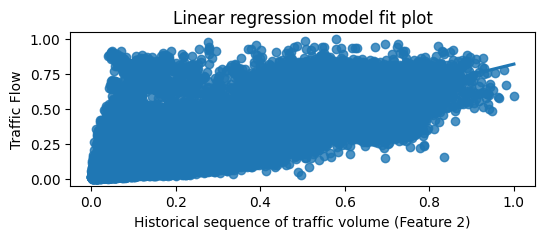

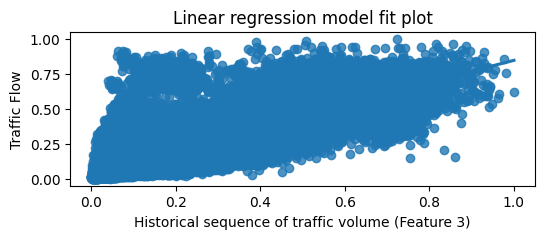

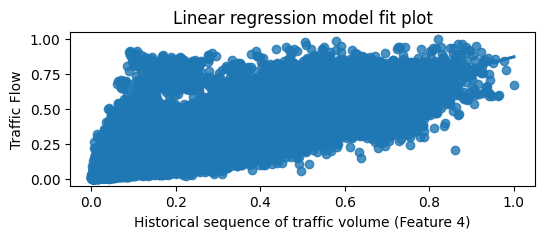

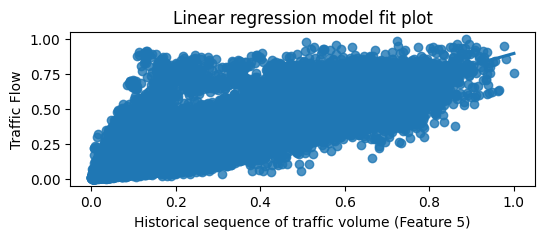

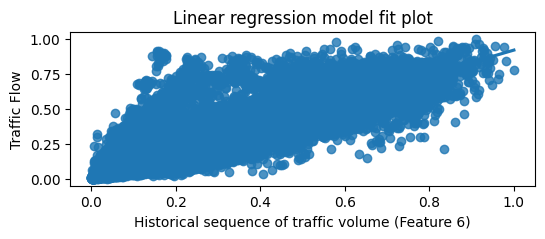

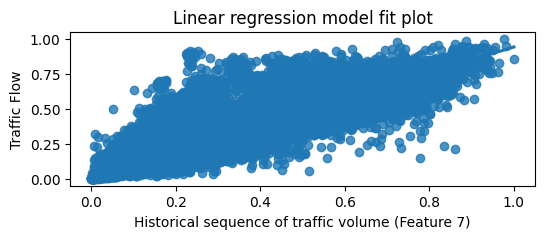

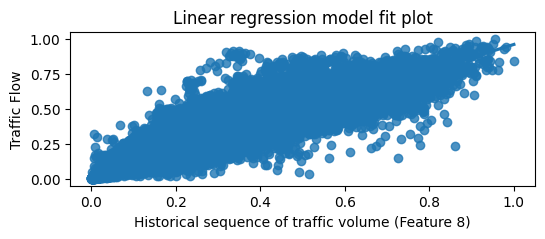

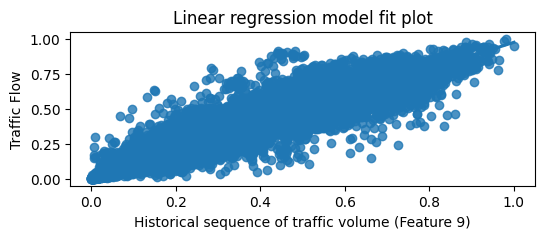

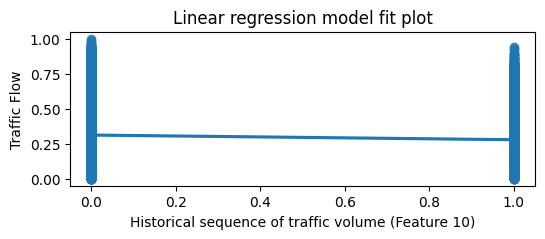

In [16]:
# Linear regression model fit plot
plotColumns =  trainDf[['1','2','3','4','5','6','7','8', '9','10']]    
for col in plotColumns:
    f, ax = plt.subplots(figsize=(6, 2))
    ax = sns.regplot(x=plotColumns[col], y=trainDf["49"], data=plotColumns)
    plt.title("Linear regression model fit plot")
    plt.xlabel('Historical sequence of traffic volume (Feature '+col+')')
    plt.ylabel('Traffic Flow')
    plt.show()
    

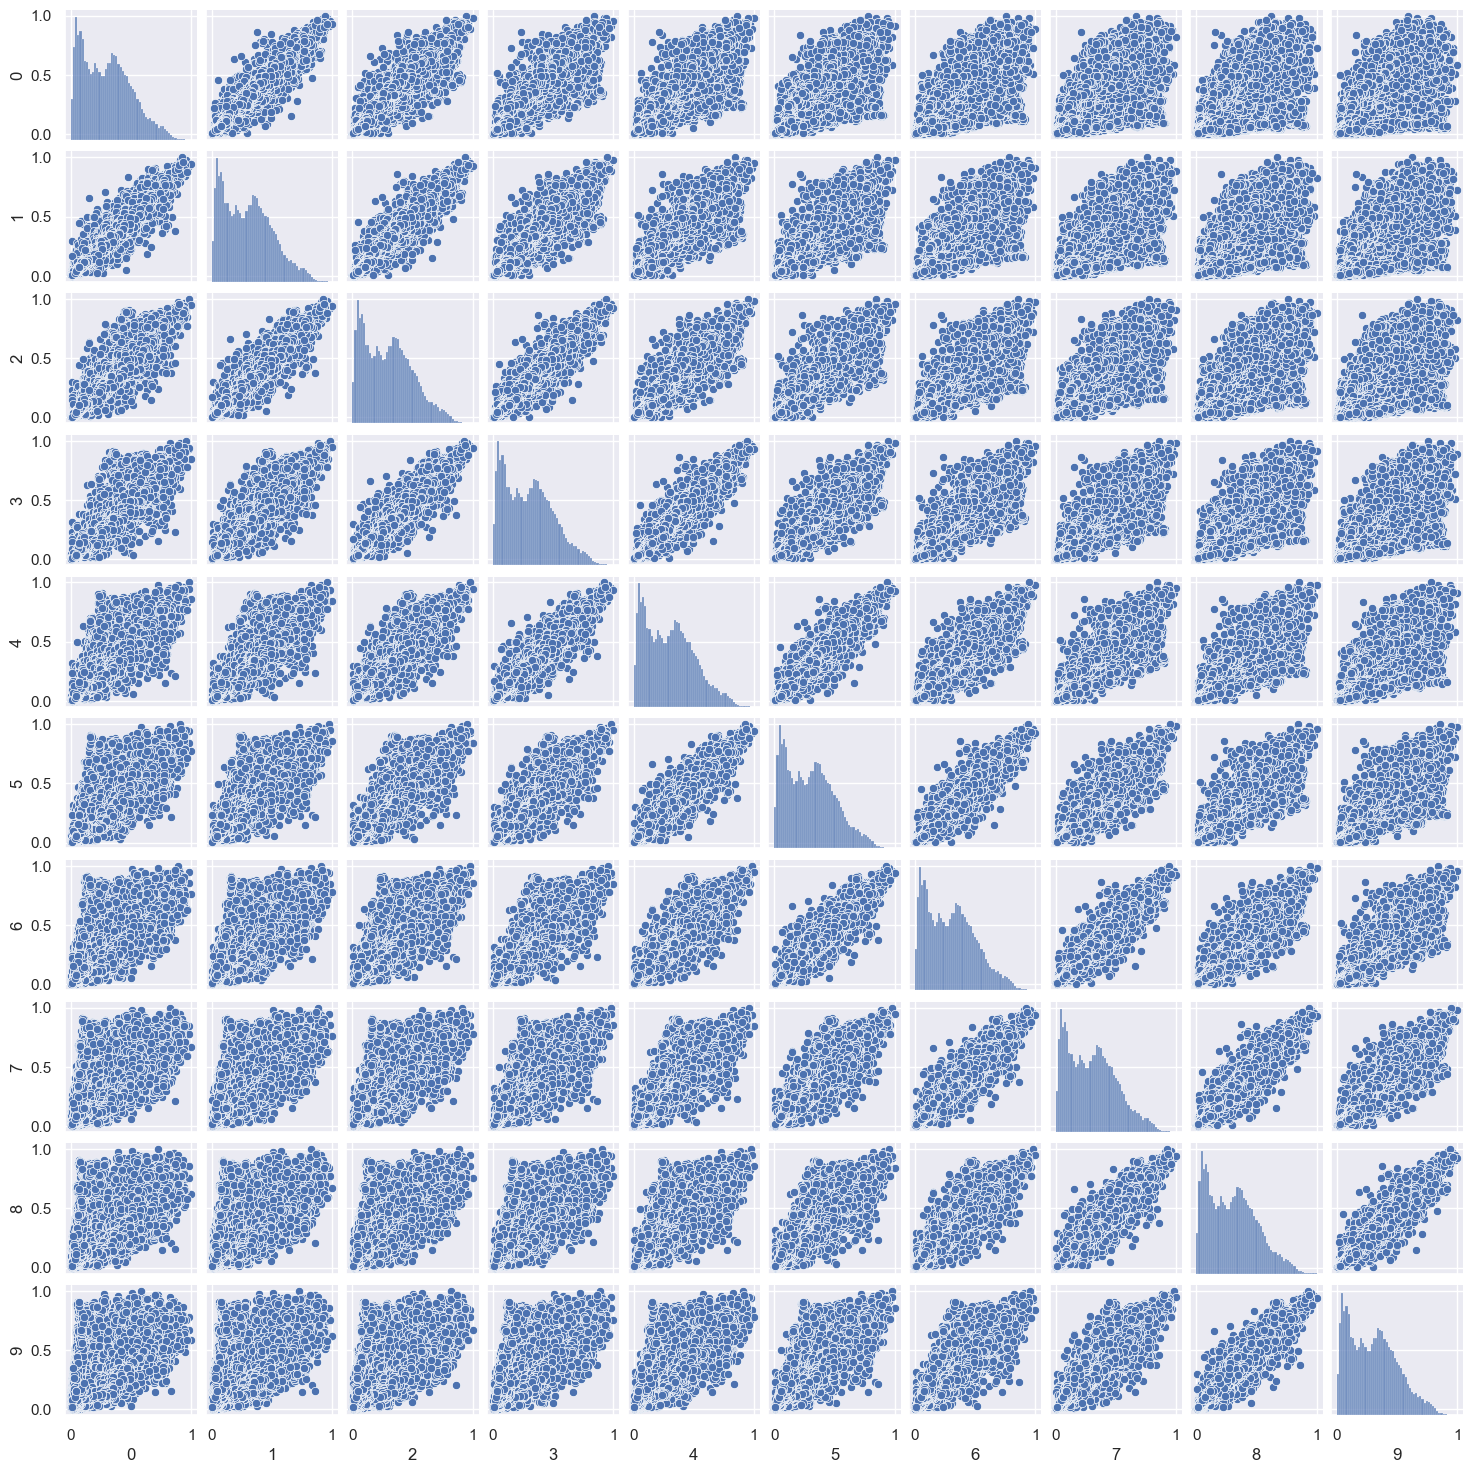

In [17]:
# pairplot
sns.set()
cols = ['0','1','2','3','4','5','6','7','8', '9']
sns.pairplot(trainDf[cols], size = 1.5)
plt.show()

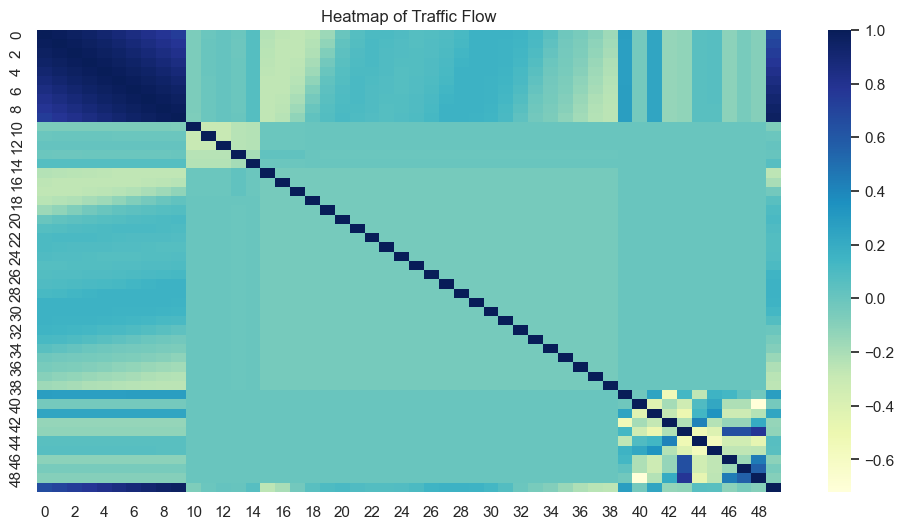

In [18]:
# Heatmap of Traffic Flow
f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(trainDf.corr(), cmap="YlGnBu")
plt.title("Heatmap of Traffic Flow")
# displaying heatmap
plt.show()

# Significant Feature Ranking
This section details the importance of features for robust machine learning model building. Feature selection is the method of reducing the input variable to the model by using only relevant data and getting rid of noise in the data. 

Build the python function for features ranking name called feature_ranking(). This function is used to select relevant features for the machine learning model. feature_ranking() takes the input as X- Predictor variable, Y - Label/target variable and colnames - Name of the predictor variable. feature_ranking() return the result as the meanplot - mean ranking of the predictor variable for features selection/ranking.

feature_ranking() method can be used as feature selection, variable selection, attribute selection or variable subset selection. In another word, feature selection is the process of selecting a subset of relevant features for use in model construction.

The following plot shows the mean ranking of features of the traffic flow prediction dataset


In [19]:
# Extract the input variable and target variable from trainDf
X = trainDf.drop(['48','49'],  axis=1)

Y = trainDf[['49']]

# Store the column/feature names into a list "colnames"
colnames = list(X.columns)

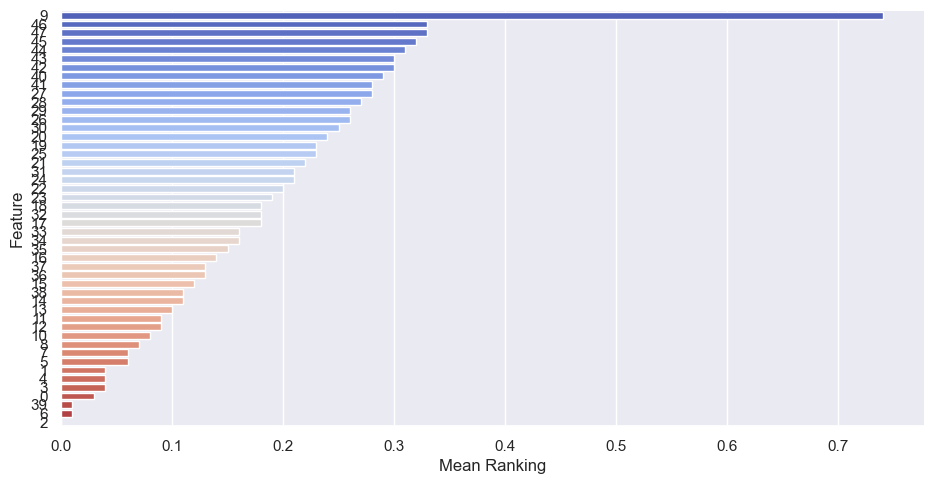

In [20]:
# Plot the ranking of the features
meanplot = feature_ranking(X,Y, colnames)

sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=5, aspect=1.9, palette='coolwarm')

In [21]:
# sort the mean ranking of the features
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
meanplot

,Feature,Mean Ranking
9,9,0.74
47,47,0.33
46,46,0.33
45,45,0.32
44,44,0.31
43,43,0.30
42,42,0.30
40,40,0.29
41,41,0.28
27,27,0.28


In [22]:
# select the features based on Mean Ranking for model training
columnName = meanplot.loc[meanplot['Mean Ranking']  >= 0.05]
columnName = list(columnName.Feature)
print("No of Feature: ", len(columnName))
print("Columns Name: ", columnName)

No of Feature:  41
Columns Name:  ['9', '47', '46', '45', '44', '43', '42', '40', '41', '27', '28', '26', '29', '30', '20', '19', '25', '21', '31', '24', '22', '23', '32', '17', '18', '33', '34', '35', '16', '37', '36', '15', '38', '14', '13', '12', '11', '10', '8', '7', '5']


# Choosing machine learning algorithms for model training

Choosing machine learning algorithms for model training is one of the important steps in data mining. The choice of the machine learning algorithms is based on the given problem statement.
For this linear problem statement chosen models are

1. K-Neighbors Regressor
2. linear regression
3. Ridge regression models
4. Random forest regressor
5. decision tree
6. Support vector regressor

# Model training and evaluation
This section details machine learning model building and evaluation of the models. A prepared dataset was used to train and test the ML model performance. Split the training dataset into 70:30 ratios, where  70 portions were used for the model training and 30 portions were used for the model testing. 

For model training, tried many permutations and combinations of features selection/ranking and trained and tested the chosen linear models.  Finally, the Mean ranking of the features greater than equal to 0.05 (section 4) is selected for the ML model training. 

The performance evaluation report includes the R2 Score, Mean Square Error(MSE) and Root Mean Square Error(RMSE) of the chosen ML models. The ML models performance evaluation report was sorted in descending order.


In [23]:
# Extract the input variable and target variable of the trainDF
X = trainDf[columnName]
y = trainDf[['49']]


In [24]:
# split original data [i.e X and y] into 70:30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Create the performance report as R2 Score, Mean Square Error(MSE), Root Mean Square Error(RMSE) of the given models
model_name = []
r2_score = []
mse = []
rmse = []

def regression_report(ModelName, model_object):
    '''
    This function Create the performance evaluation report as R2 Score, Mean Square Error(MSE), Root Mean Square Error(RMSE)
    and print Regression report of the given models
    Input
        ModelName: Name of the ML model
        model_object: Object of the initialized ML model
    Output
        Print Regression report of the given models
    
    '''
    model_object.fit(X_train, y_train)
    y_test_pred = model_object.predict(X_test)
    
    model_name.append(ModelName)
    # print("Model Name:", ModelName)
    r2 = round(metrics.r2_score(y_test, y_test_pred), 4)
    r2_score.append(r2)
    # print("r2_score:", r2)
    
    MeanSquareError = round(mean_squared_error(y_test, y_test_pred), 4)
    mse.append(MeanSquareError)
    # print("Mean Square Error", MeanSquareError)
    
    RootMeanSquareError = round(math.sqrt(mean_squared_error(y_test, y_test_pred)),4)
    rmse.append(RootMeanSquareError)
    # print("Root Mean Square Error", RootMeanSquareError)
    

# Train the Linear models
linears = {
    "Linear Regression": LinearRegression(normalize =True),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Support Vector Regression": SVR(),
    "Ridge Regression": Ridge(),
    "K-Neighbors Regressor" : KNeighborsRegressor(),
        }

for key, val in linears.items():
    regression_report(key,val)
    # print('\n')
    
# Train the Random Forest Regressor model
trees = [21,31,51]

for tree in trees:
    rf = RandomForestRegressor(n_estimators = tree)
    regression_report("Random Forest Regressor #tree: "+ str(tree), rf)
    # print('\n')

    
evaluation_poly = pd.DataFrame({'Model Name' : model_name,
                                'R squared' : r2_score,
                                'MSE' : mse,
                                'RMSE' : rmse})

evaluation_poly.sort_values(['R squared'], ascending=False, inplace = True)
print("Performance evaluation report of the models as: \n",  evaluation_poly)

Performance evaluation report of the models as: 
                           Model Name  R squared     MSE    RMSE
7  Random Forest Regressor #tree: 51     0.9629  0.0015  0.0385
6  Random Forest Regressor #tree: 31     0.9627  0.0015  0.0386
5  Random Forest Regressor #tree: 21     0.9620  0.0015  0.0389
4              K-Neighbors Regressor     0.9612  0.0015  0.0394
3                   Ridge Regression     0.9461  0.0022  0.0464
0                  Linear Regression     0.9460  0.0022  0.0464
2          Support Vector Regression     0.9360  0.0026  0.0505
1            Decision Tree Regressor     0.9282  0.0029  0.0535


# Model selection
This section details the machine learning model selection and prediction of the given test traffic flow dataset.

According to the performance evaluation report, the Random Forest Regressor #tree: 51 model performance is better as shown in above result. Random Forest Regressor #tree: 51 is selected for further prediction and analytics. 


In [26]:
# Extract the input variable and target variable of the testDF
x_test_actual = testDf[columnName]
y_test_actual = testDf[['49']]

In [27]:
# Train the Linear Regression model
rf =  RandomForestRegressor(n_estimators = 51) #KNeighborsRegressor() #LinearRegression(normalize =True)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
    
# Print the Linear Regression model report
print("Performance evaluation report as ")
r2 = round(metrics.r2_score(y_test, y_test_pred), 4)
print("r2_score: ", r2)
MeanSquareError = round(mean_squared_error(y_test, y_test_pred), 4)
print("Mean Square Error: ", MeanSquareError)
RootMeanSquareError = round(math.sqrt(mean_squared_error(y_test, y_test_pred)),4)
print("Root Mean Square Error: ", RootMeanSquareError)


Performance evaluation report as 
r2_score:  0.9628
Mean Square Error:  0.0015
Root Mean Square Error:  0.0385


# Model Prediction

In [28]:
# predict the x_test_actual and print the model PREDICTION report
y_test_pred = rf.predict(x_test_actual)

print("Prediction performance report as ")
r2 = round(metrics.r2_score(y_test_actual, y_test_pred), 4)
print("r2_score: ", r2)
MeanSquareError = round(mean_squared_error(y_test_actual, y_test_pred), 4)
print("Mean Square Error: ", MeanSquareError)
RootMeanSquareError = round(math.sqrt(mean_squared_error(y_test_actual, y_test_pred)),4)
print("Root Mean Square Error: ", RootMeanSquareError)


Prediction performance report as 
r2_score:  0.9626
Mean Square Error:  0.0016
Root Mean Square Error:  0.0395


# Observation

The overall prediction performance report of the Random Forest Regressor #tree: 51 model as R2 Score, Mean Square Error(MSE) and Root Mean Square Error(RMSE) is shown above. Over time, with training, the model gets better at predicting. 



# Identified and addressed the data quality issues

1.  Noise on Day-of-Week Features (Features 10 to Features 16)
For many matrices of tra_X_tr, it was found that roughly 8.88% of 45396 records have 1 in two features out of 7 features (from features 1 to features 16) that represent the day of the week. As shown below, for Matrix 0 of tra_X_tr, both column 10 and column 15 include 1, which can be misleading as it can only be one day of the week (i.e., either Monday or Saturday).
Handled the Noise in day-of-week features in the model training and evaluation (section 6) by choosing the features that were most relevant for model building as discussed in Significant Feature Ranking (section 4).

2. Ambiguity around Feature 39 values in 24-hour_of_day features
The Ambiguity was found in the values of feature 39 which was represented as 24-hour_of_day features. This Ambiguity was handled in the model training and evaluation by dropping feature 39 from the model training and evaluation (section 6).

3. Date discrepancy between tra_Y_te and tra_Y_tr
* The date format is misleading as to whether it is YYYY-MM-DD or YYYY-DD-MM.
* tra_Y_te is for 840 quarter-hours which are roughly 8.75 days of data and tra_Y_tr is for 1261 quarter-hours which are roughly 13 days of data. The difference in starting dates between tra_Y_tr and tra_Y_te is roughly 30 days.

As per the problem statement to predict the Traffic flow, we choose the machine learning linear models for model training and evaluation and the Date discrepancy between tra_Y_te and tra_Y_tr was taken care of and handled during the model training and evaluation (section 6).
